In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys,inspect
#sys.path.insert(0,"..")
os.chdir('..')

In [3]:
!pwd

/home/hasib/masksup-recognition


In [4]:
import os 
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms


try:
    from torchvision.transforms import InterpolationMode

    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
    

In [5]:
def to_numpy(tensor):
    return (
        tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    )


def _convert_image_to_rgb(image):
    return image.convert("RGB")


def preprocess_img(img):
    transform = transforms.Compose(
        [
            transforms.Resize(448, BICUBIC),
            transforms.CenterCrop(448),
            #_convert_image_to_rgb,
            transforms.ToTensor(),
        ]
    )
    return transform(img)

In [6]:
scribbles_folder = './datasets/SCRIBBLES'
scribbles_paths = sorted(glob.glob(scribbles_folder + "/*.png"))[::-1][:1000] # For heavy masking [::-1] 
scribbles_paths[:5]
# https://github.com/hasibzunair/masksup-segmentation/blob/master/notebooks/exp_dataloader.ipynb

['./datasets/SCRIBBLES/11999.png',
 './datasets/SCRIBBLES/11998.png',
 './datasets/SCRIBBLES/11997.png',
 './datasets/SCRIBBLES/11996.png',
 './datasets/SCRIBBLES/11995.png']

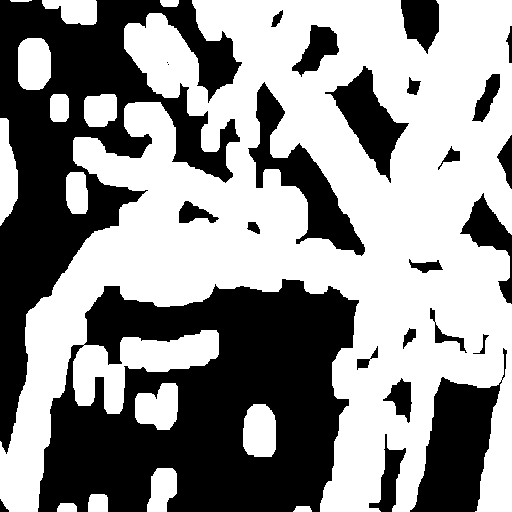

In [7]:
scribble = Image.open(scribbles_paths[2]).convert('P')
scribble

In [8]:
scribble_pre = preprocess_img(scribble)
scribble_pre

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.8824, 0.8824, 0.8824],
         [0.0000, 0.0000, 0.0000,  ..., 0.8824, 0.8824, 0.8824],
         [0.0000, 0.0000, 0.0000,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.8824, 0.8824, 0.8824],
         [0.0000, 0.0000, 0.0000,  ..., 0.8824, 0.8824, 0.8824],
         [0.0000, 0.0000, 0.0000,  ..., 0.8824, 0.8824, 0.8824]]])

In [9]:
scribble_pre.size

<function Tensor.size>

### Masked data loader experiment

In [10]:
from torch.utils.data import DataLoader


from pipeline.dataset import DataSetMaskSup

train_file = ["data/voc07/trainval_voc07.json"]
test_file = ["data/voc07/test_voc07.json"]
step_size = 4


train_dataset = DataSetMaskSup(train_file, ["randomflip", "resizedcrop"], 448, "voc07")
test_dataset = DataSetMaskSup(test_file, [], 448, "voc07")

train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=8
)
test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=False, num_workers=8
)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomResizedCrop(size=(448, 448), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    Resize(size=(448, 448), interpolation=bilinear)
)
Compose(
    Resize(size=(448, 448), interpolation=bilinear)
)


In [11]:
dt = next(iter(train_loader))
x = dt["img"]
xm = dt["masked_img"]
#s = dt["scribble"]
y = dt["target"]

x.shape, xm.shape, y.shape

(torch.Size([16, 3, 448, 448]),
 torch.Size([16, 3, 448, 448]),
 torch.Size([16, 20]))

In [12]:
import torch 

import numpy as np 
import matplotlib.pyplot as plt

# def to_img(ten):
#     ten =(ten[0].permute(1,2,0).detach().cpu().numpy()+1)/2
#     ten=(ten*255).astype(np.uint8)
#     return ten

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def to_img_(ten):
    curr_img = ten.detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0, 0, 0]), # mean and std
                           torch.tensor([1, 1, 1])) 
    curr_img = curr_img.permute((1, 2, 0))
    return curr_img


# a = to_img_(x[7])
# print(a.shape)
# plt.imshow(a)

torch.Size([448, 448, 3])


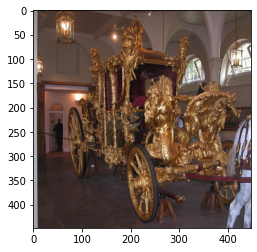

In [13]:
a = to_img_(x[7])
print(a.shape)
plt.imshow(a)

In [14]:
a.shape

torch.Size([448, 448, 3])

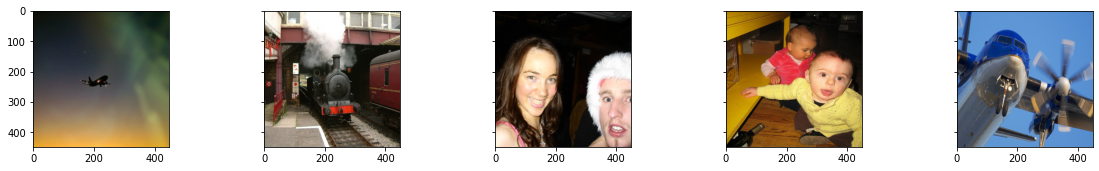

In [15]:
n_images = 5

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))

for i in range(5):
    axes[i].imshow(to_img_(x[i]))

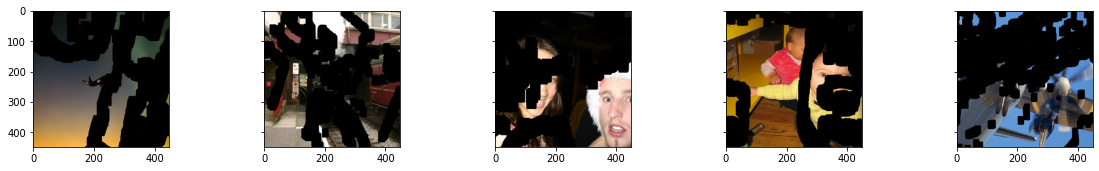

In [16]:
n_images = 5

fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))

for i in range(5):
    axes[i].imshow(to_img_(xm[i]))

In [20]:
# n_images = 5

# fig, axes = plt.subplots(nrows=1, ncols=n_images, 
#                          sharex=True, sharey=True, figsize=(20, 2.5))

# for i in range(5):
#     axes[i].imshow(to_img_(s[i]), cmap="gray")

In [18]:
# a = to_img_(s[0])
# np.unique(a)